In [11]:
import time
start = time.perf_counter()

In [33]:
import time
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
from sklearn.random_projection import GaussianRandomProjection
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.model_selection import cross_val_score,  GridSearchCV, StratifiedShuffleSplit, learning_curve, validation_curve, GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, auc, confusion_matrix, roc_curve, roc_auc_score, recall_score, f1_score, classification_report, precision_score, homogeneity_score, normalized_mutual_info_score, davies_bouldin_score, mean_squared_error, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [34]:
np.random.seed(903967645)

In [35]:
default_payment_dataset = pd.read_csv('../data/default_of_credit_card_clients.csv', header=1)
print(default_payment_dataset.info())
default_payment_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [36]:
# Check shape of dataset and for null data
print(default_payment_dataset.shape)
default_payment_dataset.isna().any().any()
print(default_payment_dataset.columns)

(30000, 25)
Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')


In [37]:
default_payment_dataset = default_payment_dataset.sample(frac=1.0, random_state=42)

# Separate features and target
train_X = default_payment_dataset.drop(columns=['ID', 'default payment next month', 'BILL_AMT4', 'BILL_AMT3', 'BILL_AMT6', 'BILL_AMT1', 'BILL_AMT2'])
train_y = default_payment_dataset['default payment next month']

# Normalize the feature data
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(train_X)

# Convert back to DataFrame
train_X = pd.DataFrame(X_scaled, columns=train_X.columns)
print(train_X.shape)

(30000, 18)


In [30]:
dims = list(range(2, 19, 1))

For dimension=2, the rc_err is 0.06363927772363466
For dimension=3, the rc_err is 0.06139055379877301
For dimension=4, the rc_err is 0.06032350625528656
For dimension=5, the rc_err is 0.059428337227902514
For dimension=6, the rc_err is 0.058761840899367396
For dimension=7, the rc_err is 0.058260549071007445
For dimension=8, the rc_err is 0.057956513143546134
For dimension=9, the rc_err is 0.05775148108883616
For dimension=10, the rc_err is 0.0576000031474264
For dimension=11, the rc_err is 0.05745682457583918
For dimension=12, the rc_err is 0.0573565002211836
For dimension=13, the rc_err is 0.05728528074842568
For dimension=14, the rc_err is 0.0572297198393594
For dimension=15, the rc_err is 0.0571990660411708
For dimension=16, the rc_err is 0.057178579433929996
For dimension=17, the rc_err is 0.05716339886560651
For dimension=18, the rc_err is 0.0571550449029906


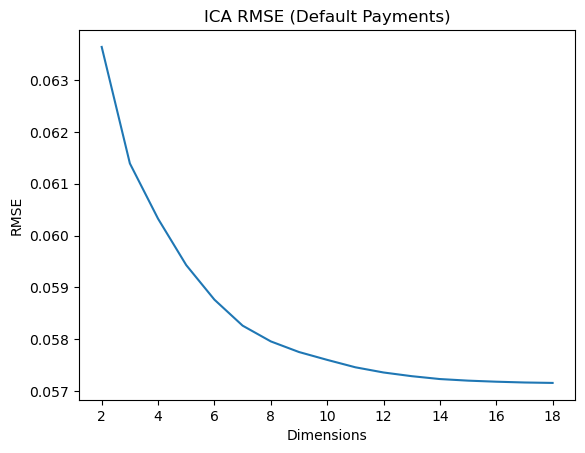

CPU times: user 2min 34s, sys: 29.3 s, total: 3min 3s
Wall time: 19.5 s


In [31]:
%%time

rc_errors = {}

for dim in dims:
    ica = FastICA(n_components=dim, random_state=42)
    x_prime = ica.fit_transform(train_X.values)

    A = np.linalg.pinv(ica.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(train_X.values, reconstructed)
    rc_errors[dim] = rc_err
    print(f"For dimension={dim}, the rc_err is {rc_err}")


plt.figure()
plt.plot(list(rc_errors.keys()), list(rc_errors.values()))
plt.xlabel('Dimensions')
plt.ylabel('RMSE')
plt.title('ICA RMSE (Default Payments)')
plt.savefig('../images/default-payments-ica-rmse.png')
plt.show()

In [38]:
comp = 5
ica = FastICA(n_components=comp, random_state=42, max_iter=1000)
ica_result = ica.fit_transform(train_X.values)
for i in range(comp):
    field_name = "ica-"+str(i)
    train_X[field_name] = ica_result[:,i]
    default_payment_dataset[field_name] = ica_result[:,i]
train_X_ica = ica_result

In [39]:
kurtosis_values = kurtosis(ica_result, fisher=True)

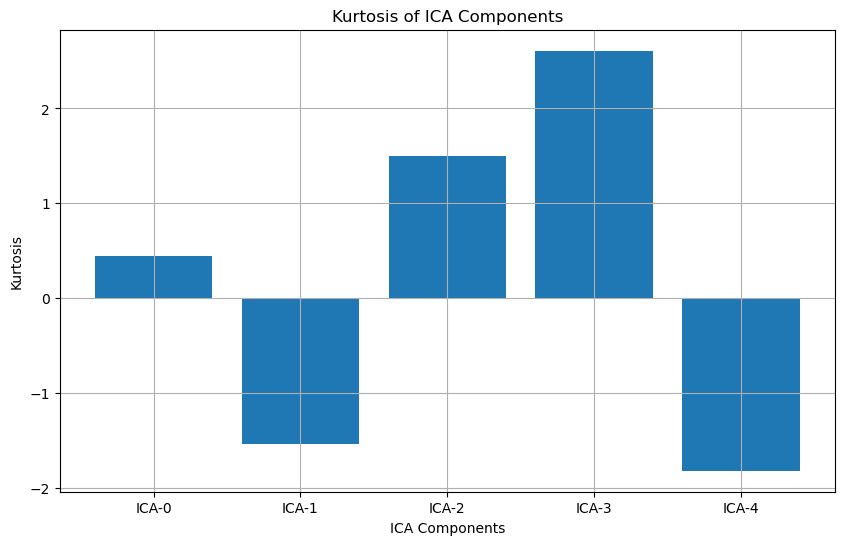

In [40]:
# Plot kurtosis values
plt.figure(figsize=(10, 6))
plt.bar(range(comp), kurtosis_values, tick_label=[f'ICA-{i}' for i in range(comp)])
plt.xlabel('ICA Components')
plt.ylabel('Kurtosis')
plt.title('Kurtosis of ICA Components')
plt.grid(True)
plt.savefig('../images/default-payments-ica-kurtosis.png')
plt.show()

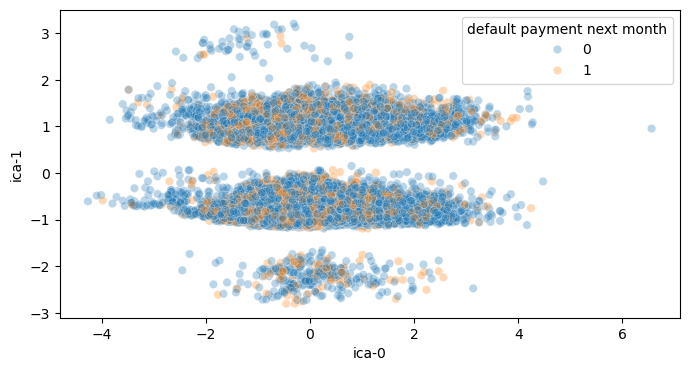

In [41]:
plt.figure(figsize=(8,4))
sns.scatterplot(
    x='ica-0', y='ica-1',
    hue='default payment next month',
    palette=sns.color_palette('tab10', 2),
    data=default_payment_dataset,
    legend='full',
    alpha=0.3
)
plt.savefig('../images/default-payments-ica-2d')

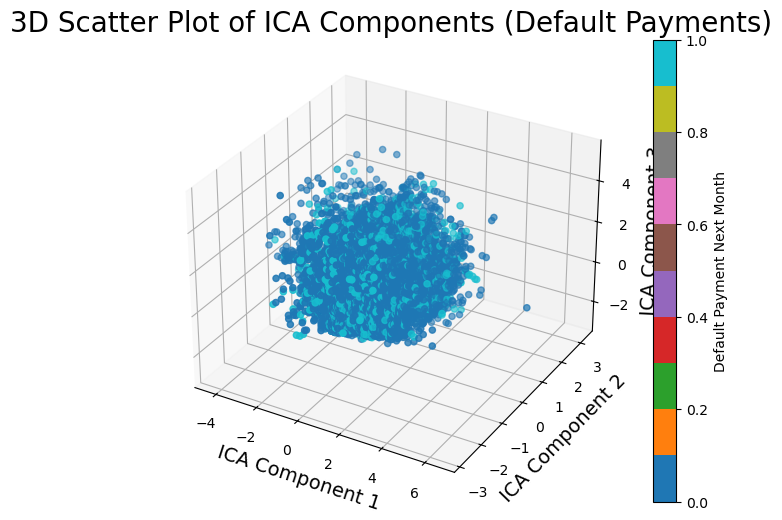

In [44]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    xs=default_payment_dataset["ica-0"], 
    ys=default_payment_dataset["ica-1"], 
    zs=default_payment_dataset["ica-2"], 
    c=default_payment_dataset["default payment next month"], 
    cmap='tab10'
)
ax.set_xlabel('ICA Component 1', fontsize=14)
ax.set_ylabel('ICA Component 2', fontsize=14)
ax.set_zlabel('ICA Component 3', fontsize=14)
ax.set_title('3D Scatter Plot of ICA Components (Default Payments)', fontsize=20)
plt.colorbar(scatter, ax=ax, label='Default Payment Next Month')
plt.savefig('../images/default-payments-ica-3d')
plt.show()

In [11]:
print(f"Rank of reduced ICA Default Payments dataset: {np.linalg.matrix_rank(train_X_ica)}")

Rank of reduced ICA Default Payments dataset: 5


In [13]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

vif_results = calculate_vif(train_X_ica)
print(f"Average VIF: {vif_results['VIF'].mean()}")
print(vif_results)
print(vif_results.head(10))

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [ ]:
correlation_matrix = train_X_ica.corr()
print(correlation_matrix)

### Noise

In [46]:
def add_gaussian_noise(data, noise_level):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

In [47]:
def evaluate_dr_performance(dr_technique, X, y, n_components):
    dr = dr_technique(n_components=n_components, random_state=42)
    X_reduced = dr.fit_transform(X)
    
    # Here, you can use any relevant metric. For this example, we'll use silhouette score
    score = silhouette_score(X_reduced, y)
    return score

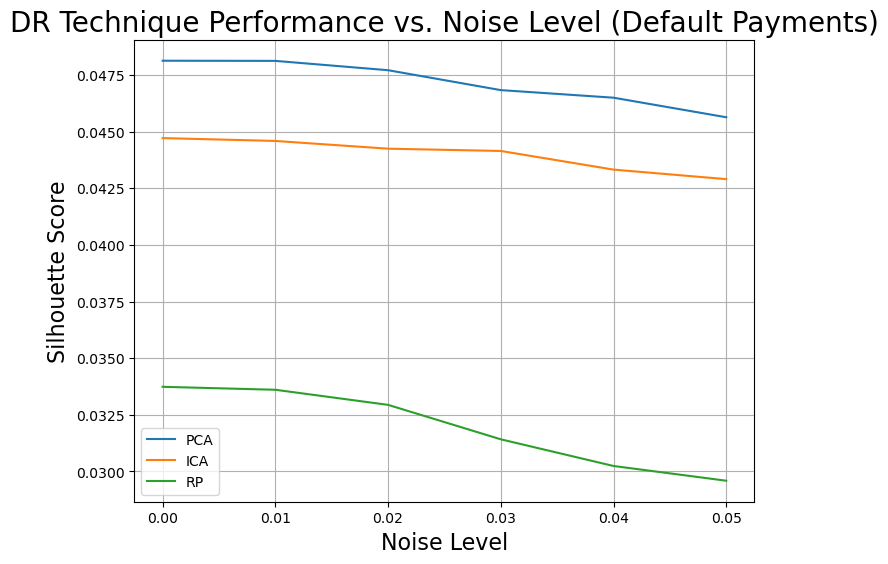

In [48]:
noise_levels = [0, 0.01, 0.02, 0.03, 0.04, 0.05]  # 0% to 5% noise
dr_techniques = {'PCA': PCA, 'ICA': FastICA, 'RP': GaussianRandomProjection}
n_components = 5  # or whatever number you choose

results = {}

for technique_name, technique in dr_techniques.items():
    technique_results = []
    for noise_level in noise_levels:
        noisy_data = add_gaussian_noise(X_scaled, noise_level)
        score = evaluate_dr_performance(technique, noisy_data, train_y, n_components)
        technique_results.append(score)
    results[technique_name] = technique_results

# Plot results
plt.figure(figsize=(8, 6))
for technique, scores in results.items():
    plt.plot(noise_levels, scores, label=technique)
plt.xlabel('Noise Level', fontsize=16)
plt.ylabel('Silhouette Score', fontsize=16)
plt.title('DR Technique Performance vs. Noise Level (Default Payments)', fontsize=20)
plt.legend()
plt.grid(True)
plt.savefig('../images/dr_noise_sensitivity.png')
plt.show()

# Clustering

In [ ]:
%%time
silhouette_coeffs_km = {}
homogeneity_scores_km = {}

for cluster in range(2, 31, 1):
    kmeans = KMeans(n_clusters=cluster, n_init=10, max_iter=25, random_state=42).fit(train_X_ica)
    label = kmeans.labels_
    sil_coeff = silhouette_score(train_X_ica, label, metric='euclidean')
    homog_score = homogeneity_score(train_y, label)
    silhouette_coeffs_km[cluster] = sil_coeff
    homogeneity_scores_km[cluster] = homog_score
    print(f"For n_clusters={cluster}, The Silhouette Coefficient is {sil_coeff}")
    print(f"For n_clusters={cluster}, The homogeneity_score is {homog_score}")
    
# Plotting Silhouette Coefficients
plt.figure(figsize=(8, 4))
plt.plot(list(silhouette_coeffs_km.keys()), list(silhouette_coeffs_km.values()), marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title("KMeans Silhouette Coefficient for Various Numbers of Clusters ICA (Defaults Payment)")
plt.grid(True)
fig.savefig('../images/default-payments-ica-kmeans-silhouette.png')
plt.show()

In [ ]:
# Plotting Silhouette Coefficient and Homogeneity Score
plt.figure(figsize=(8, 4))
plt.plot(list(silhouette_coeffs_km.keys()), list(silhouette_coeffs_km.values()), 'b', label='Silhouette Coefficient KMeans', marker='o')
plt.plot(list(homogeneity_scores_km.keys()), list(homogeneity_scores_km.values()), 'r', label='Homogeneity Score KMeans', marker='x')
plt.legend(loc='best')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('KMeans Silhouette Coefficient and Homogeneity Score for Various Numbers of Clusters ICA (Default Payments)')
plt.savefig('../images/default-payments--ica-em-silhouette-coefficient')
plt.grid(True)
plt.show()

In [ ]:
%%time
silhouette_coeffs_EM = {}
homogeneity_scores_EM = {}
log_likelihood_EM = {}


for cluster in range(2, 31, 1):
    gmm = GaussianMixture(n_components=cluster, n_init=10, max_iter=50, random_state=42).fit(train_X_ica)
    label = gmm.predict(train_X_ica)
    sil_coeff = silhouette_score(train_X_ica, label, metric='euclidean')
    homog_score = homogeneity_score(train_y, label)
    silhouette_coeffs_EM[cluster] = sil_coeff
    homogeneity_scores_EM[cluster] = homog_score
    log_likelihood_EM[cluster] = gmm.score(train_X)
    print(f"For n_clusters={cluster}, The Silhouette Coefficient is {sil_coeff}")
    print(f"For n_clusters={cluster}, The homogeneity_score is {homog_score}")
    print(f"For n_clusters={cluster}, The log likelihood score is {log_likelihood_EM[cluster]}")

    
# Plotting Silhouette Coefficients
plt.figure(figsize=(8, 4))
plt.plot(list(silhouette_coeffs_EM.keys()), list(silhouette_coeffs_EM.values()), marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title("Expectation Maximization Silhouette Coefficient for Various Numbers of Clusters ICA (GMM) (Default Payments)")
plt.grid(loc='best')
plt.savefig('../images/default-payments--ica-em-silhouette-coefficient')
plt.show()

In [ ]:
# Plotting Silhouette Coefficient and Homogeneity Score
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_coeffs_EM.keys()), list(silhouette_coeffs_EM.values()), 'b', label='Silhouette Coefficient', marker='o')
plt.plot(list(homogeneity_scores_EM.keys()), list(homogeneity_scores_EM.values()), 'r', label='Homogeneity Score', marker='x')
plt.legend(loc='best')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Coefficient and Homogeneity Score for Various Numbers of Clusters ICA (GMM) (Default Payments)')
plt.grid(True)
plt.savefig('../images/default-payments--ica-em-silhouette-and-homogeneity')
plt.show()

In [27]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(train_X_ica)
kmeans_labels = kmeans.labels_

In [28]:
train_X['KMeans_Cluster'] = kmeans_labels

In [29]:
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(train_X_ica)
gmm_labels = gmm.predict(train_X_ica)

In [30]:
train_X['GMM_Cluster'] = gmm_labels
print(train_X.head())

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE       AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   0.020202  0.0   0.333333  0.666667  0.068966    0.2    0.2    0.2    0.2   
1   0.141414  1.0   0.166667  0.666667  0.086207    0.2    0.2    0.2    0.2   
2   0.060606  1.0   0.500000  0.333333  0.189655    0.2    0.2    0.2    0.2   
3   0.121212  0.0   0.500000  0.666667  0.482759    0.2    0.2    0.2    0.2   
4   0.040404  1.0   0.333333  0.666667  0.258621    0.2    0.2    0.2    0.2   

   PAY_5  ...  PAY_AMT4  PAY_AMT5  PAY_AMT6     ica-0     ica-1     ica-2  \
0    0.2  ...  0.002415  0.003517  0.003783 -1.022918 -1.038197  0.236641   
1    0.2  ...  0.004262  0.006257  0.005049  0.632883 -1.055486  0.820757   
2    0.2  ...  0.003926  0.005861  0.004831 -0.581343  0.785153 -0.237830   
3    0.2  ...  0.000043  0.016437  0.008338 -0.175347 -0.334800 -2.377597   
4    0.2  ...  0.002899  0.000000  0.001892 -0.194058 -0.707288 -0.776133   

      ica-3     ica-4  KMeans_Cluster  GMM_Cluster  
0  

In [31]:
features_to_plot = ['ica-0', 'ica-1']
# Get unique clusters for KMeans and GMM
unique_clusters_kmeans = np.unique(train_X['KMeans_Cluster'])
unique_clusters_gmm = np.unique(train_X['GMM_Cluster'])

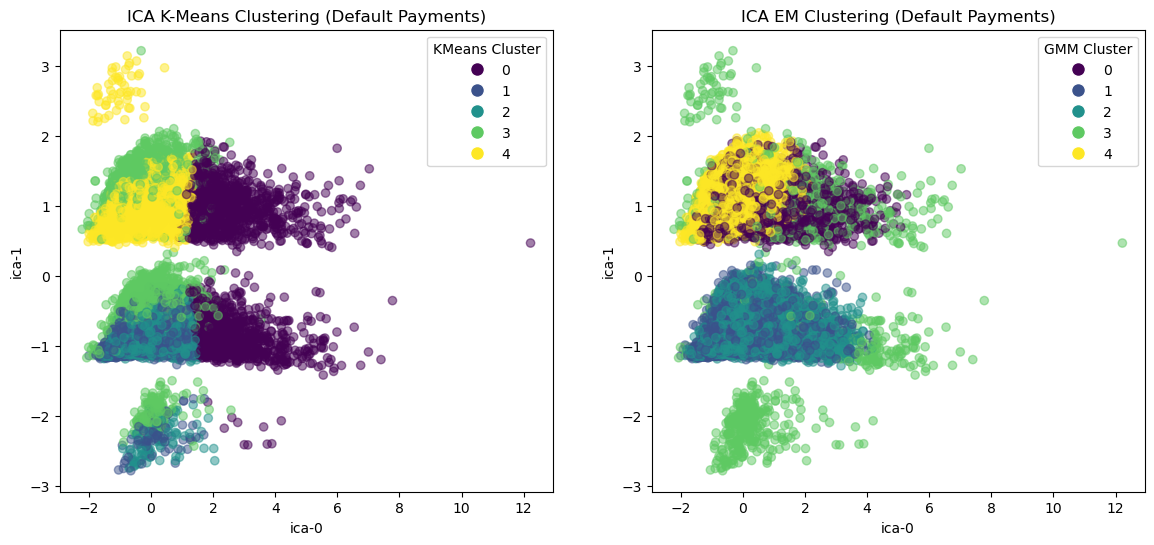

In [32]:
# Create a figure with subplots
plt.figure(figsize=(14, 6))

# Plot K-Means clustering results
plt.subplot(1, 2, 1)
scatter_kmeans = plt.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['KMeans_Cluster'], cmap='viridis', alpha=0.5)
plt.title('ICA K-Means Clustering (Default Payments)')
plt.xlabel(features_to_plot[0])
plt.ylabel(features_to_plot[1])
handles_kmeans = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_kmeans.cmap(scatter_kmeans.norm(cluster)), markersize=10) for cluster in unique_clusters_kmeans]
plt.legend(handles_kmeans, unique_clusters_kmeans, title='KMeans Cluster', loc='best')

# Plot GMM clustering results
plt.subplot(1, 2, 2)
scatter_gmm = plt.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
plt.title('ICA EM Clustering (Default Payments)')
plt.xlabel(features_to_plot[0])
plt.ylabel(features_to_plot[1])
handles_gmm = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_gmm.cmap(scatter_gmm.norm(cluster)), markersize=10) for cluster in unique_clusters_gmm]
plt.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best')

# Save the plot
plt.savefig('../images/default-payments-ica-clustering-comparison.png')

# Show the plot
plt.show()

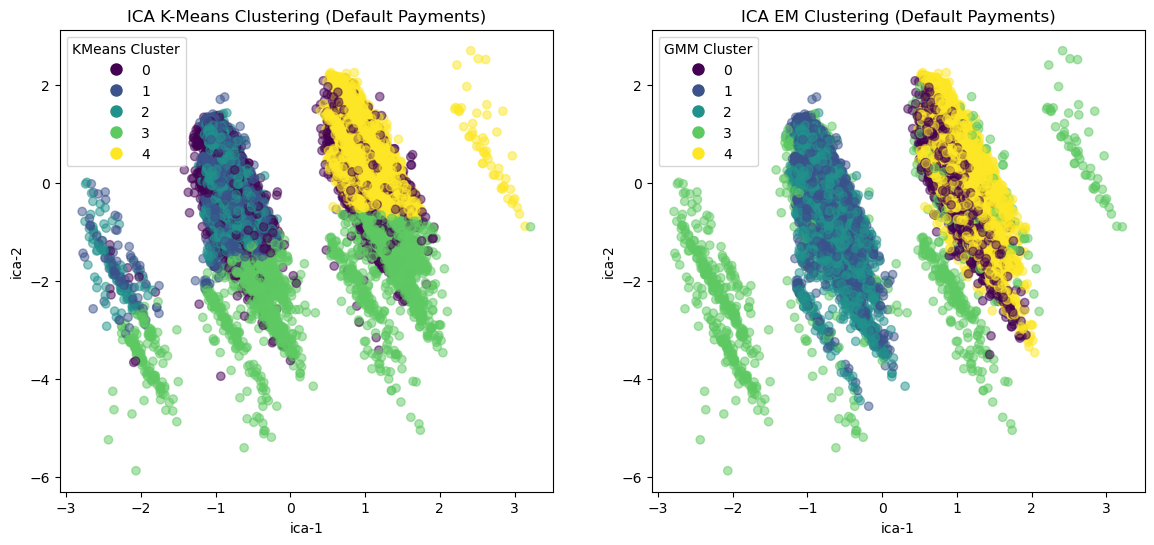

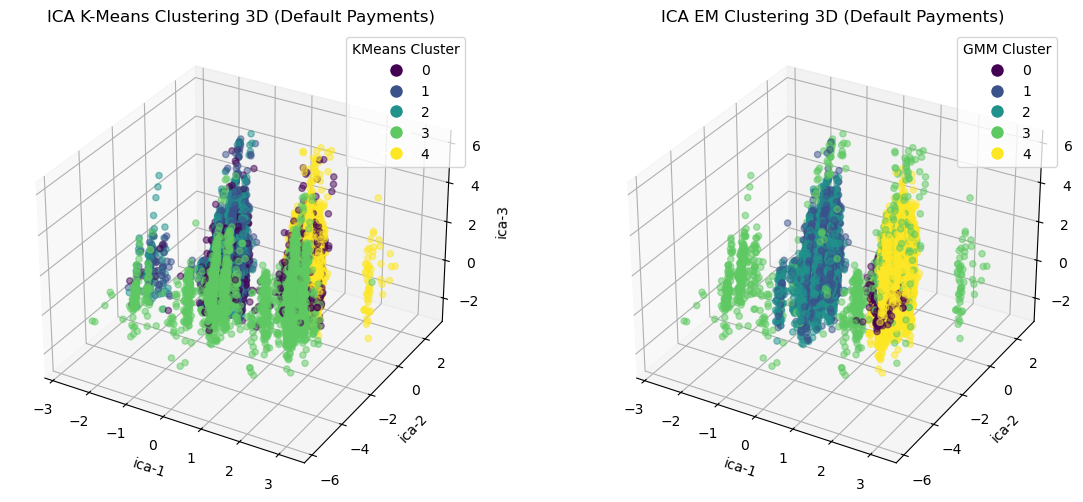

In [38]:
# Define the features you want to plot in 3D
features_to_plot_3d = ['ica-1', 'ica-2', 'ica-3']

# Create a figure for 2D K-Means and EM clustering results
fig_2d = plt.figure(figsize=(14, 6))

# 2D Plot for K-Means clustering results
ax1 = fig_2d.add_subplot(121)
scatter_kmeans = ax1.scatter(train_X[features_to_plot_3d[0]], train_X[features_to_plot_3d[1]], c=train_X['KMeans_Cluster'], cmap='viridis', alpha=0.5)
ax1.set_title('ICA K-Means Clustering (Default Payments)')
ax1.set_xlabel(features_to_plot_3d[0])
ax1.set_ylabel(features_to_plot_3d[1])
handles_kmeans = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_kmeans.cmap(scatter_kmeans.norm(cluster)), markersize=10) for cluster in unique_clusters_kmeans]
ax1.legend(handles_kmeans, unique_clusters_kmeans, title='KMeans Cluster', loc='best')

# 2D Plot for EM clustering results
ax2 = fig_2d.add_subplot(122)
scatter_gmm = ax2.scatter(train_X[features_to_plot_3d[0]], train_X[features_to_plot_3d[1]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
ax2.set_title('ICA EM Clustering (Default Payments)')
ax2.set_xlabel(features_to_plot_3d[0])
ax2.set_ylabel(features_to_plot_3d[1])
handles_gmm = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_gmm.cmap(scatter_gmm.norm(cluster)), markersize=10) for cluster in unique_clusters_gmm]
ax2.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best')

fig_2d.savefig('../images/default-payments-comparison-ica-2D.png')
plt.show()

# Create a figure for 3D K-Means and EM clustering results
fig_3d = plt.figure(figsize=(14, 6))

# 3D Plot for K-Means clustering results
ax1 = fig_3d.add_subplot(121, projection='3d')
scatter_kmeans_3d = ax1.scatter(train_X[features_to_plot_3d[0]], train_X[features_to_plot_3d[1]], train_X[features_to_plot_3d[2]], c=train_X['KMeans_Cluster'], cmap='viridis', alpha=0.5)
ax1.set_title('ICA K-Means Clustering 3D (Default Payments)')
ax1.set_xlabel(features_to_plot_3d[0])
ax1.set_ylabel(features_to_plot_3d[1])
ax1.set_zlabel(features_to_plot_3d[2], rotation=90)
ax1.legend(handles_kmeans, unique_clusters_kmeans, title='KMeans Cluster', loc='best')

# 3D Plot for EM clustering results
ax2 = fig_3d.add_subplot(122, projection='3d')
scatter_gmm_3d = ax2.scatter(train_X[features_to_plot_3d[0]], train_X[features_to_plot_3d[1]], train_X[features_to_plot_3d[2]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
ax2.set_title('ICA EM Clustering 3D (Default Payments)')
ax2.set_xlabel(features_to_plot_3d[0])
ax2.set_ylabel(features_to_plot_3d[1])
ax2.set_zlabel(features_to_plot_3d[2])
ax2.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best')

fig_3d.savefig('../images/default-payments-comparison-ica-3D.png')
plt.show()

In [37]:
# Calculate ARI
ari_score = adjusted_rand_score(train_X['KMeans_Cluster'], train_X['GMM_Cluster'])
print(f'Adjusted Rand Index (ARI) between KMeans and GMM clusters ICA: {ari_score}')

# Calculate NMI
nmi_score = normalized_mutual_info_score(train_X['KMeans_Cluster'], train_X['GMM_Cluster'])
print(f'Normalized Mutual Information (NMI) between KMeans and GMM clusters ICA: {nmi_score}')

Adjusted Rand Index (ARI) between KMeans and GMM clusters ICA: 0.6111717114989931
Normalized Mutual Information (NMI) between KMeans and GMM clusters ICA: 0.5943804151079568


# Neural Network

In [60]:
%%time

# Ensure train_X_grp and train_y are pandas DataFrames/Series
train_X_ica = pd.DataFrame(train_X_ica)
train_y = pd.Series(train_y)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(train_X_ica, train_y):
    strat_train_set = train_X_ica.iloc[train_index]
    strat_test_set = train_X_ica.iloc[test_index]
    strat_train_labels = train_y.iloc[train_index]
    strat_test_labels = train_y.iloc[test_index]

train_X_ica = strat_train_set
test_X_ica = strat_test_set
train_y = strat_train_labels
test_y = strat_test_labels

CPU times: user 11 ms, sys: 5.17 ms, total: 16.1 ms
Wall time: 13.3 ms


In [61]:
neural_net = MLPClassifier(random_state=42)
neural_net.fit(train_X_ica, train_y)

MLPClassifier(random_state=42)

In [62]:
%%time
# Evaluate on training data
train_predictions = neural_net.predict(train_X_ica)
train_accuracy = accuracy_score(train_y, train_predictions)
train_roc_auc = roc_auc_score(train_y, train_predictions)
train_precision = precision_score(train_y, train_predictions)
train_recall = recall_score(train_y, train_predictions)
train_f1 = f1_score(train_y, train_predictions)

print("Training Accuracy:", train_accuracy)
print("Training ROC AUC Score:", train_roc_auc)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1)
train_report = classification_report(train_y, train_predictions)
print(train_report)

# Write to a text file
with open('../results/default-payments-nn-ica-training_metrics_report.txt', 'w') as file:
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Training ROC AUC Score: " + str(train_roc_auc) + "\n")
    file.write("Training Precision: " + str(train_precision) + "\n")
    file.write("Training Recall: " + str(train_recall) + "\n")
    file.write("Training F1 Score: " + str(train_f1) + "\n")
    file.write("\nClassification Report:\n")
    file.write(train_report + "\n")

Training Accuracy: 0.8055416666666667
Training ROC AUC Score: 0.6313985166196703
Training Precision: 0.616897305171158
Training Recall: 0.31908080617818796
Training F1 Score: 0.4206083178150217
              precision    recall  f1-score   support

           0       0.83      0.94      0.88     18691
           1       0.62      0.32      0.42      5309

    accuracy                           0.81     24000
   macro avg       0.72      0.63      0.65     24000
weighted avg       0.78      0.81      0.78     24000

CPU times: user 504 ms, sys: 211 ms, total: 716 ms
Wall time: 108 ms


In [63]:
%%time
# Evaluate testing data
test_predictions = neural_net.predict(test_X_ica)
test_accuracy = accuracy_score(test_y, test_predictions)
test_roc_auc = roc_auc_score(test_y, test_predictions)
test_precision = precision_score(test_y, test_predictions)
test_recall = recall_score(test_y, test_predictions)
test_f1 = f1_score(test_y, test_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing ROC AUC Score:", test_roc_auc)
print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)
print("Testing F1 Score:", test_f1)
test_report = classification_report(test_y, test_predictions)
print(test_report)

# Write to a text file
with open('../results/default-payments-nn-ica-testing_metrics_report.txt', 'w') as file:
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Testing ROC AUC Score: " + str(test_roc_auc) + "\n")
    file.write("Testing Precision: " + str(test_precision) + "\n")
    file.write("Testing Recall: " + str(test_recall) + "\n")
    file.write("Testing F1 Score: " + str(test_f1) + "\n")
    file.write("\nClassification Report:\n")
    file.write(test_report + "\n")

Testing Accuracy: 0.8068333333333333
Testing ROC AUC Score: 0.6366841308541702
Testing Precision: 0.6179775280898876
Testing Recall: 0.3315749811605124
Testing F1 Score: 0.4315841098577734
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4673
           1       0.62      0.33      0.43      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.64      0.66      6000
weighted avg       0.78      0.81      0.78      6000

CPU times: user 235 ms, sys: 91.4 ms, total: 326 ms
Wall time: 44.2 ms


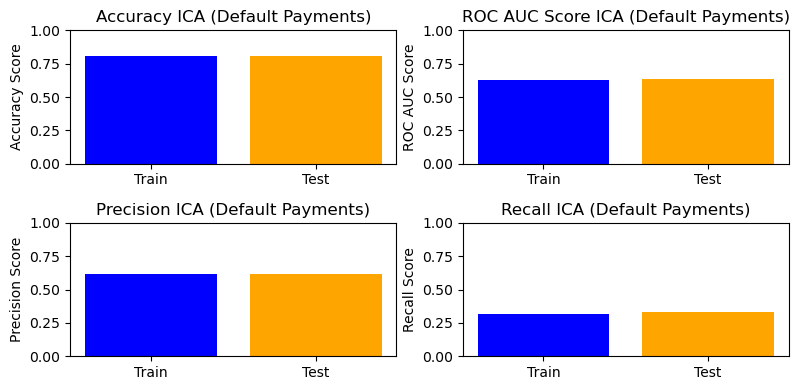

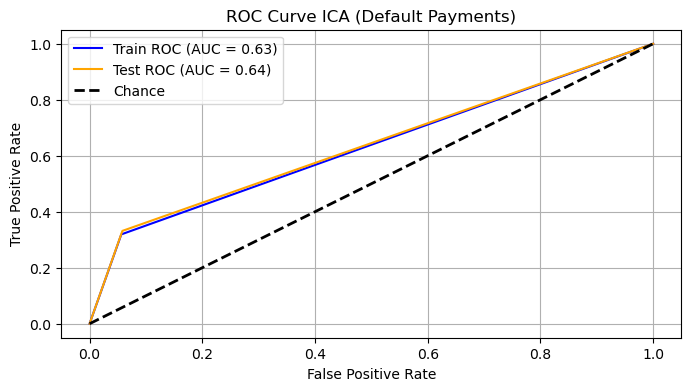

CPU times: user 792 ms, sys: 16 ms, total: 808 ms
Wall time: 292 ms


In [64]:
%%time
fig, ax = plt.subplots(2, 2, figsize=(8, 4))

# Accuracy
ax[0, 0].bar(['Train', 'Test'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
ax[0, 0].set_title('Accuracy ICA (Default Payments)')
ax[0, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel('Accuracy Score')

# ROC AUC Score
ax[0, 1].bar(['Train', 'Test'], [train_roc_auc, test_roc_auc], color=['blue', 'orange'])
ax[0, 1].set_title('ROC AUC Score ICA (Default Payments)')
ax[0, 1].set_ylim([0, 1])
ax[0, 1].set_ylabel('ROC AUC Score')

# Precision
ax[1, 0].bar(['Train', 'Test'], [train_precision, test_precision], color=['blue', 'orange'])
ax[1, 0].set_title('Precision ICA (Default Payments)')
ax[1, 0].set_ylim([0, 1])
ax[1, 0].set_ylabel('Precision Score')

# Recall
ax[1, 1].bar(['Train', 'Test'], [train_recall, test_recall], color=['blue', 'orange'])
ax[1, 1].set_title('Recall ICA (Default Payments)')
ax[1, 1].set_ylim([0, 1])
ax[1, 1].set_ylabel('Recall Score')

plt.tight_layout()
fig.savefig('../images/default-payments-nn-ica-metrics-comparison.png')
plt.show()

# Plotting  ROC Curves
train_fpr, train_tpr, _ = roc_curve(train_y, train_predictions)
test_fpr, test_tpr, _ = roc_curve(test_y, test_predictions)

plt.figure(figsize=(8, 4))
plt.plot(train_fpr, train_tpr, label=f'Train ROC (AUC = {auc(train_fpr, train_tpr):.2f})', color='blue')
plt.plot(test_fpr, test_tpr, label=f'Test ROC (AUC = {auc(test_fpr, test_tpr):.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve ICA (Default Payments)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/default-payments-nn-ica-roc-curve')
plt.show()

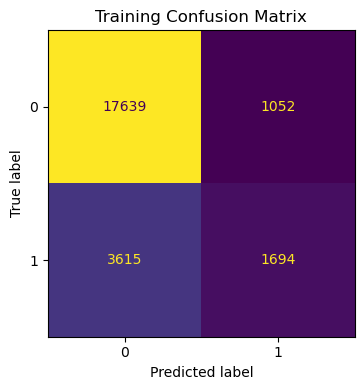

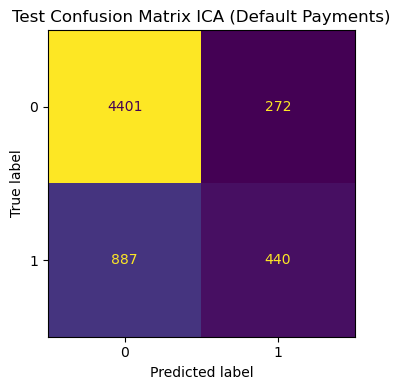

CPU times: user 365 ms, sys: 12.3 ms, total: 377 ms
Wall time: 141 ms


In [65]:
%%time
# Plot and save Training Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
train_cm = confusion_matrix(train_y, train_predictions)
ConfusionMatrixDisplay(train_cm).plot(ax=ax, colorbar=False)
ax.set_title("Training Confusion Matrix")
plt.tight_layout()
plt.savefig('../images/default-payments-nn-ica-training-cm.png')
plt.show()

# Plot and save Test Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
test_cm = confusion_matrix(test_y, test_predictions)
ConfusionMatrixDisplay(test_cm).plot(ax=ax, colorbar=False)
ax.set_title('Test Confusion Matrix ICA (Default Payments)')
plt.tight_layout()
plt.savefig('../images/default-payments-nn-ica-testing-cm.png')
plt.show()

Training progress:   0%|                                                                                                                                                                     | 0/10 [00:00<?, ?it/s]/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn'

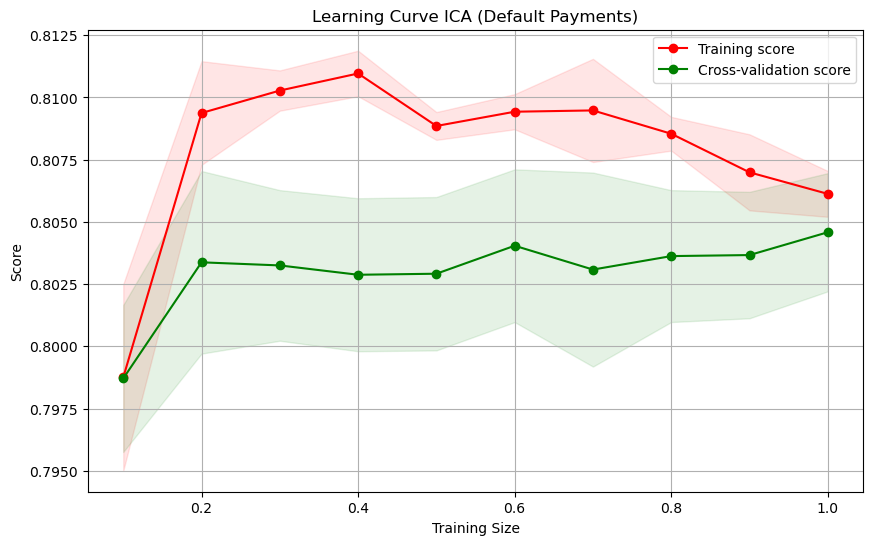

CPU times: user 16min 59s, sys: 49.9 s, total: 17min 49s
Wall time: 1min 52s


In [66]:
%%time
# Create a wrapper function for learning_curve to show progress
def learning_curve_with_progress(estimator, X, y, cv, scoring, train_sizes):
    all_train_scores = []
    all_test_scores = []
    for train_size in tqdm(train_sizes, desc='Training progress'):
        _, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=[train_size], cv=cv, scoring=scoring)
        all_train_scores.append(train_scores)
        all_test_scores.append(test_scores)
    return train_sizes, np.array(all_train_scores).squeeze(), np.array(all_test_scores).squeeze()

train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve_with_progress(neural_net, train_X_ica, train_y, cv=5, scoring='accuracy', train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.title('Learning Curve ICA (Default Payments)')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/default-payments-nn-ica-learning-curve-training-size.png')
plt.show()

Validation progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.93s/it]


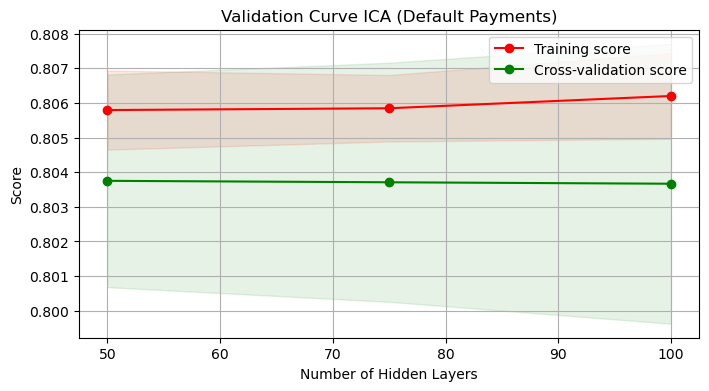

CPU times: user 703 ms, sys: 650 ms, total: 1.35 s
Wall time: 8.96 s


In [67]:
%%time
param_range = [50, 75, 100]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

train_scores, test_scores = validation_curve_with_progress(MLPClassifier(), train_X_ica, train_y, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, 'o-', color='r', label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color='g', label="Cross-validation score")

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.title('Validation Curve ICA (Default Payments)')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/default-payments-nn-ica-validation-curve-hidden-layers.png')
plt.show()

Validation progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:20<00:00,  3.42s/it]


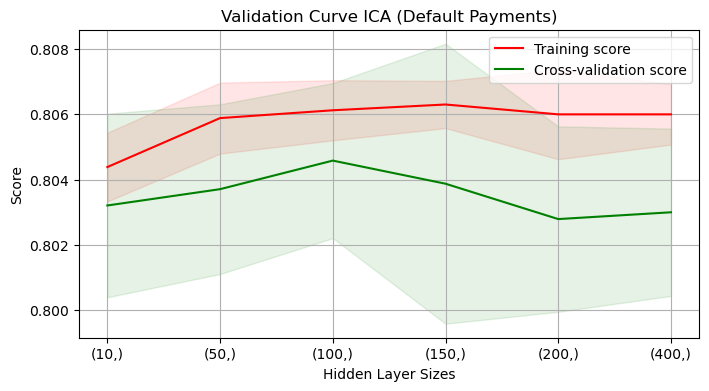

CPU times: user 312 ms, sys: 53.8 ms, total: 366 ms
Wall time: 20.6 s


In [69]:
%%time
# Define the range for the hyperparameter hidden_layer_sizes
param_range = [(10,), (50,), (100,), (150,), (200,), (400,)]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

# Calculate validation curve data
train_scores, test_scores = validation_curve_with_progress(
    MLPClassifier(random_state=42), train_X_ica, train_y, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot([str(x) for x in param_range], train_scores_mean, label="Training score", color="r")
plt.plot([str(x) for x in param_range], test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between([str(x) for x in param_range], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between([str(x) for x in param_range], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title("Validation Curve ICA (Default Payments)")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/default-payments-nn-ica-validation-curve-hidden-layer-sizes-2.png')
plt.show()

In [70]:
%%time
# Perform 10-fold cross-validation
cv_scores = cross_val_score(neural_net, train_X_ica, train_y, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("mean cross-validation score:", cv_scores.mean())

# Write cross-validation scores to a text file
with open('../results/default-payments-nn-ica-cross_validation_scores.txt', 'w') as file:
    file.write("Cross-validation scores: " + np.array2string(cv_scores) + "\n")
    file.write("Mean cross-validation score: " + str(cv_scores.mean()) + "\n")

Cross-validation scores: [0.795      0.81208333 0.8075     0.80416667 0.80791667 0.79625
 0.80583333 0.81416667 0.80125    0.79625   ]
mean cross-validation score: 0.8040416666666668
CPU times: user 5min 50s, sys: 18.7 s, total: 6min 9s
Wall time: 39 s


              precision    recall  f1-score   support

           0       0.83      0.94      0.88     18691
           1       0.61      0.31      0.42      5309

    accuracy                           0.80     24000
   macro avg       0.72      0.63      0.65     24000
weighted avg       0.78      0.80      0.78     24000



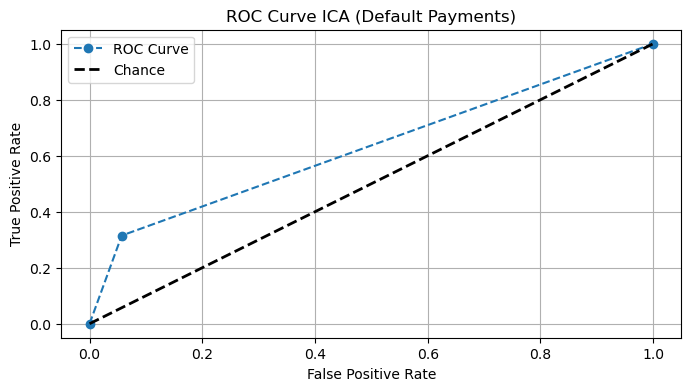

CPU times: user 9min 16s, sys: 33 s, total: 9min 49s
Wall time: 1min 13s


In [71]:
%%time
y_pred = cross_val_predict(neural_net, train_X_ica, train_y, cv=10)

report = classification_report(train_y, y_pred)
print(report)

with open('../results/default-payments-nn-ica-classification_report.txt', 'w') as file:
    file.write(report)
    
fpr, tpr, thresholds = roc_curve(train_y, y_pred, pos_label=1)
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, marker='o', linestyle='--', label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve ICA (Default Payments)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/default-payments-nn-ica-roc-curve-fpr.png')
plt.show()

/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimize

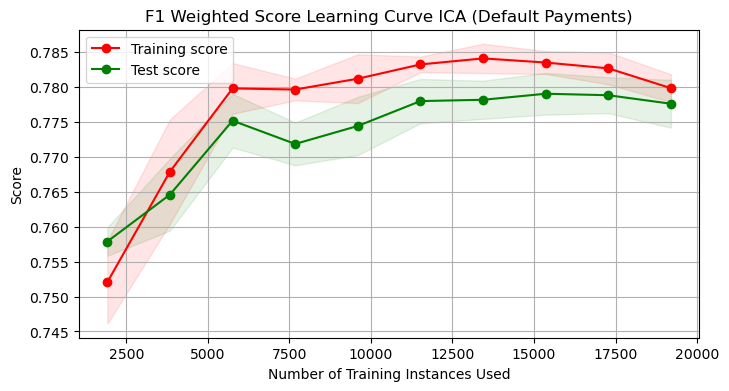

CPU times: user 391 ms, sys: 88.6 ms, total: 480 ms
Wall time: 7.45 s


In [73]:
%%time
best_mlp = MLPClassifier(
    activation='relu',
    alpha=0.0001,
    hidden_layer_sizes=(100,),
    learning_rate='adaptive',
    max_iter=100,
    solver='adam'
)

# Assuming best_mlp, train_X, train_y are already defined
train_sizes, train_scores, test_scores = learning_curve(
    best_mlp, train_X_ica, train_y, cv=5, scoring='f1_weighted',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

plt.title('F1 Weighted Score Learning Curve ICA (Default Payments)')
plt.xlabel('Number of Training Instances Used')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/default-payments-nn-ica-best-nn-training-vs-test-set')
plt.show()
# Write to a text file
with open('../results/default-payments-nn-ica-test_classification_results.txt', 'w') as file:
    file.write("Classification Report:\n")
    file.write(test_report + "\n")
    file.write("Confusion Matrix:\n")
    file.write(np.array2string(test_cm) + "\n")

In [74]:
end = time.perf_counter()
print("Time taken: in min", (end - start)/60)

Time taken: in min 9.966926293750294
